In [ ]:
# !pip install split-folders
# # !pip install tensorboard jupyter ipywidgets

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import drive

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_DIR = "/content/drive/MyDrive/AAI_Dataset/CCMT_Dataset"

In [4]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/val"
diseases = os.listdir(train_dir)

diseases = [item for item in diseases if item not in {'train', 'val', 'test'}]

# Print dieases name
print(diseases)

['red rust', 'streak virus', 'verticulium wilt', 'septoria leaf spot', 'grasshoper', 'fall armyworm', 'brown spot', 'leaf curl', 'green mite', 'gumosis', 'bacterial blight', 'anthracnose']


In [5]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 12


In [6]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

,No. of images
red rust,424
streak virus,258
verticulium wilt,321
septoria leaf spot,642
grasshoper,284
fall armyworm,228
brown spot,432
leaf curl,400
green mite,483
gumosis,313


<Figure size 1000x600 with 0 Axes>

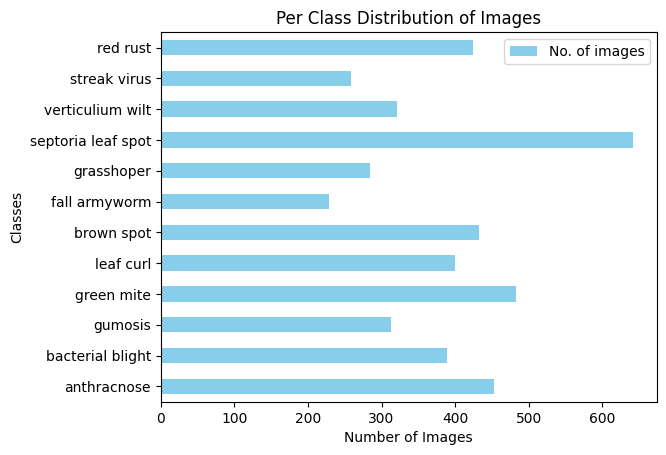

In [7]:
plt.figure(figsize=(10, 6))
img_per_class.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Per Class Distribution of Images')
plt.gca().invert_yaxis()
plt.show()

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
def is_valid_file(file_path):
    try:
        # Open the image file
        with open(file_path, 'rb') as f:
            img = Image.open(f)

            # Attempt to load the image to ensure it's valid
            img.load()
             # Verify the integrity of the image file
            img.verify()
            return True
    except Exception as e:
        # If any exception occurs during the process, consider the file as invalid
        return False


In [10]:
batch_size=64

In [11]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/CCMT_Dataset/train', transform=train_transforms,is_valid_file=is_valid_file)
val_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/CCMT_Dataset/val', transform=val_transforms,is_valid_file=is_valid_file)
test_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/CCMT_Dataset/test', transform=val_transforms,is_valid_file=is_valid_file)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


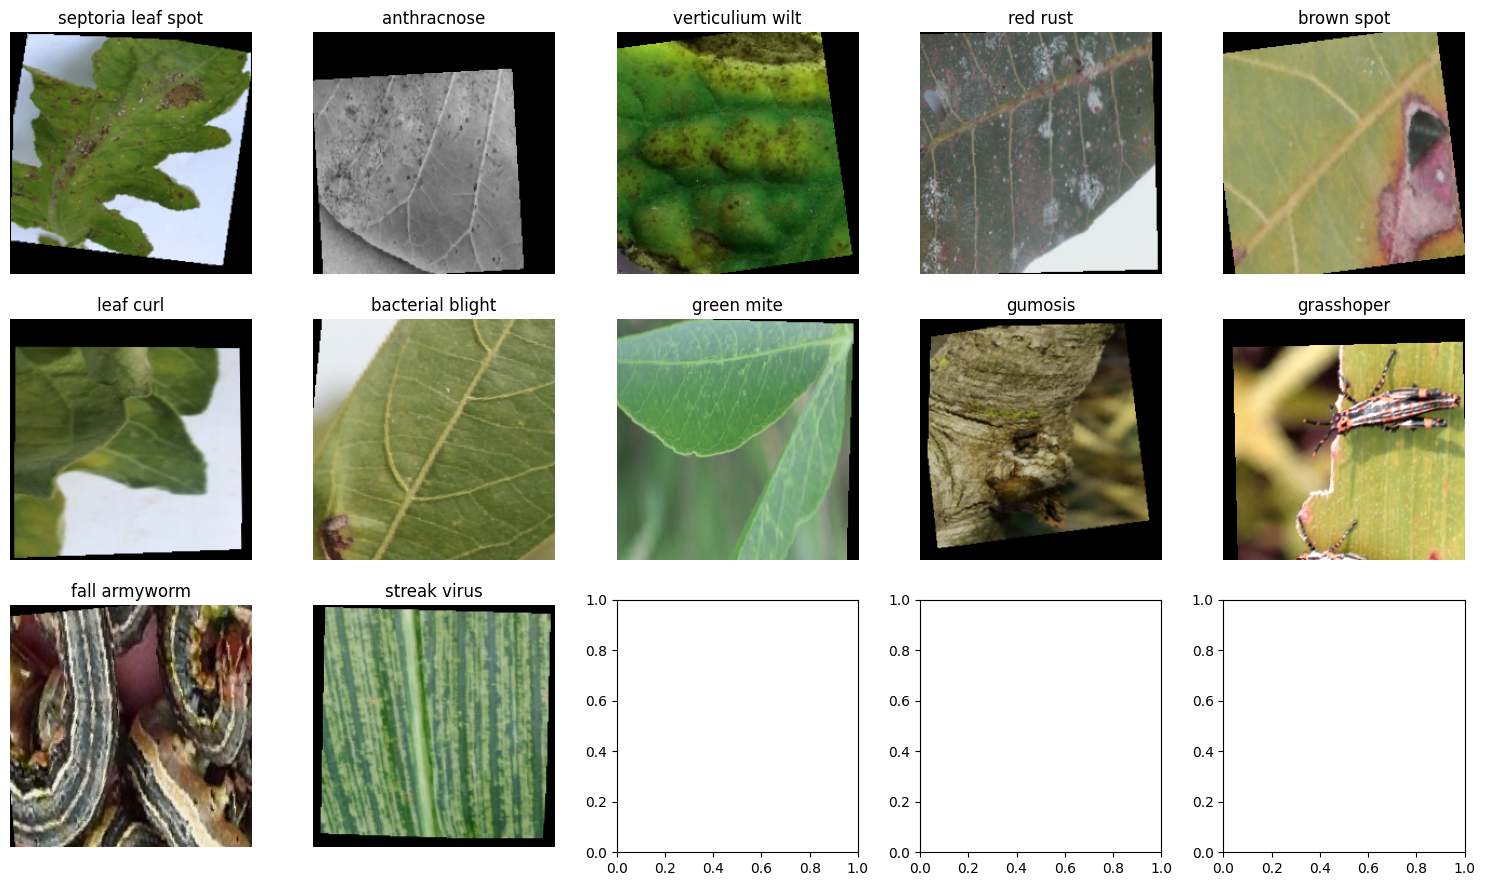

In [13]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_cols = min(5, num_classes)
num_rows = math.ceil(num_classes / num_cols)

if num_rows == 1:
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15, 5))
else:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    for image, label in zip(images, labels):
        class_name = idx_to_class[label.item()]
        if class_name not in unique_classes:
            unique_classes.add(class_name)
            if num_rows == 1:
                ax = axes[col_index]
            else:
                ax = axes[row_index, col_index]
            img = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')

            col_index += 1
            if col_index == num_cols:
                col_index = 0
                row_index += 1

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.vgg19(pretrained=True)
model.to(device)




Device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 179MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
TENSORBOARD_SUMMARY_PATH=f'{DATASET_DIR}/Rice_Leaf_Disease_Images'
writer = SummaryWriter(TENSORBOARD_SUMMARY_PATH)

In [17]:
BEST_MODEL_PATH='/content/drive/MyDrive/Rice_Leaf_Disease_Images.pth'

In [18]:
early_stopping_patience = 5
epochs_no_improve = 0
val_loss_min = np.Inf

In [19]:
def train_model(num_epochs):
    global epochs_no_improve
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        writer.add_scalar('Training loss', epoch_loss, epoch)
        writer.add_scalar('Training accuracy', epoch_acc, epoch)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / val_total
        val_accuracy = val_correct / val_total
        writer.add_scalar('Validation loss', val_loss, epoch)
        writer.add_scalar('Validation accuracy', val_accuracy, epoch)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stopping_patience:
            print('Early stopping initiated...')
            break

In [20]:
num_epochs = 10
train_model(num_epochs)

Epoch [1/10], Train Loss: 2.9316, Train Acc: 0.2902, Val Loss: 1.2552, Val Acc: 0.5459
Epoch [2/10], Train Loss: 1.1997, Train Acc: 0.5657, Val Loss: 0.7732, Val Acc: 0.7092
Epoch [3/10], Train Loss: 0.9573, Train Acc: 0.6507, Val Loss: 0.6446, Val Acc: 0.7301
Epoch [4/10], Train Loss: 0.8030, Train Acc: 0.6986, Val Loss: 0.6416, Val Acc: 0.7557
Epoch [5/10], Train Loss: 0.7437, Train Acc: 0.7161, Val Loss: 0.5252, Val Acc: 0.7942
Epoch [6/10], Train Loss: 0.6630, Train Acc: 0.7488, Val Loss: 0.5808, Val Acc: 0.7807
Epoch [7/10], Train Loss: 0.6326, Train Acc: 0.7587, Val Loss: 0.6222, Val Acc: 0.7679
Epoch [8/10], Train Loss: 0.6356, Train Acc: 0.7622, Val Loss: 0.6347, Val Acc: 0.7564
Epoch [9/10], Train Loss: 0.6071, Train Acc: 0.7691, Val Loss: 0.4132, Val Acc: 0.8333
Epoch [10/10], Train Loss: 0.5751, Train Acc: 0.7905, Val Loss: 0.4063, Val Acc: 0.8435


In [21]:
# Model evaluation
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.4f}')

writer.close()



Test Accuracy: 0.8457


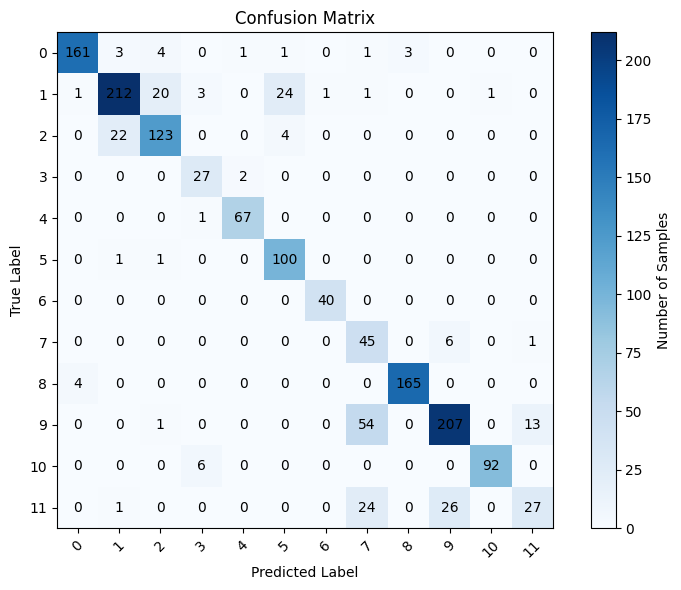

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       174
           1       0.89      0.81      0.84       263
           2       0.83      0.83      0.83       149
           3       0.73      0.93      0.82        29
           4       0.96      0.99      0.97        68
           5       0.78      0.98      0.87       102
           6       0.98      1.00      0.99        40
           7       0.36      0.87      0.51        52
           8       0.98      0.98      0.98       169
           9       0.87      0.75      0.81       275
          10       0.99      0.94      0.96        98
          11       0.66      0.35      0.45        78

    accuracy                           0.85      1497
   macro avg       0.83      0.86      0.83      1497
weighted avg       0.87      0.85      0.85      1497



In [22]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

plt.title('Confusion Matrix')
plt.colorbar(label='Number of Samples')
plt.xticks(np.arange(len(conf_matrix)), list(set(all_targets)), rotation=45)
plt.yticks(np.arange(len(conf_matrix)), list(set(all_targets)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)

In [32]:
pip install ptflops

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m